In [2]:
#import libraries
import re
import os
import random as rd
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
from scipy import sparse

2023-02-24 14:34:46.829118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 14:34:46.962873: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 14:34:46.968868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 14:34:46.968877: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
#one hot sequencing function
def ohe(seq):
    seq2=list()
    mapping = {"A":[1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [1, 0, 0, 0], "T":[0, 0, 0, 1]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0, 0, 0, 0]) 
    return np.array(seq2)

In [4]:
#fasta to ohe numpy
f=open('/home/florian/projet/r6.16/dmel-all-chromosome-r6.16.fasta','r')
os.chdir('/home/florian/projet/r6.16')
chr_name = str()
seq=[]
D={}
for line in f:
        line = line.rstrip()
        if line[0] == '>':
                if line[1:3]=="2C":
                        break
                if seq != []:
                        D[chr_name]=ohe(seq)
                chr_name = line[1:3].strip()
                seq = []
        else:
                seq += line
D["Y"]=ohe(seq)
np.savez_compressed('seq',**D)

In [3]:
len2L=len(np.load('/home/florian/projet/r6.16/seq.npz')['2L'])
len2R=len(np.load('/home/florian/projet/r6.16/seq.npz')['2R'])
len3L=len(np.load('/home/florian/projet/r6.16/seq.npz')['3L'])
len3R=len(np.load('/home/florian/projet/r6.16/seq.npz')['3R'])
len4=len(np.load('/home/florian/projet/r6.16/seq.npz')['4'])
lenX=len(np.load('/home/florian/projet/r6.16/seq.npz')['X'])
lenY=len(np.load('/home/florian/projet/r6.16/seq.npz')['Y'])

In [35]:
#bigwig to numpy
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs = []
array=np.array(())
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.concatenate((bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True)))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [31]:
#bigwig to numpy v2
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs =[]
chr=["2L","2R","3L","3R","4","X","Y"]
Dic={"2L"}
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.array(())
    for j in chr:
        array=np.append(array,bw.values(j,0,-1,numpy=True))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [ ]:
#bigwig to numpy v3
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs =[]
Dic={}
chr=["2L","2R","3L","3R","4","X","Y"]
lens=[len2L,len2R,len3L,len3R,len4,lenX,lenY]
for i in range(len(chr)):
    Dic[chr[i]]=np.zeros((1,lens[i]))
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.array(())
    for j in chr:
        Dic[j]=Dic[j]+bw.values(j,0,-1,numpy=True)

os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq_chr',**Dic)

In [4]:
#load and normalize data (also creates weights)
val=np.load('/home/florian/projet/scATACseq.npz')['valeurs']
val[val >= 2000] = 2000
val=val/2000
#weights=
bin_values, bin_edges = np.histogram(val, bins=500)
bin_indices = np.digitize(val, bin_edges)
bin_indices[bin_indices == 501] = 500
bin_indices -= 1
weights = 1 / bin_values[bin_indices]

In [91]:
a=np.load('/home/florian/projet/scATACseq.npz')['valeurs']

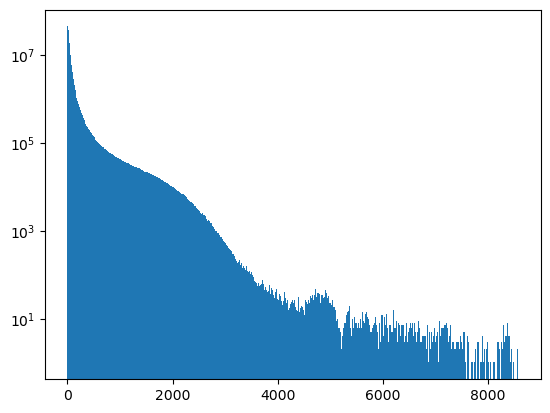

In [92]:
plt.hist(a,bins=500)
plt.yscale('log')

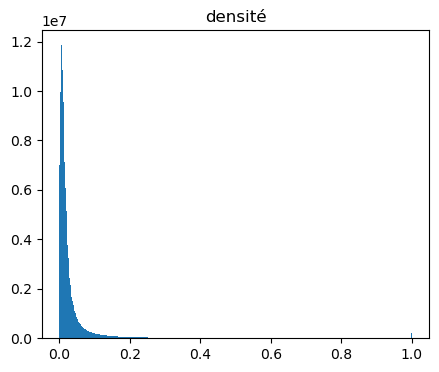

In [88]:
plt.figure(figsize=(5,4))
plt.hist(val,bins=500)#, density=True)
plt.title("densité")
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [4]:
#generator
class MySequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        #batch_x_indices = np.arange([idx * self.batch_size:(idx + 1) *self.batch_size])
        # batch_x = Xtrain_chr2L=[]
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        # for i in batch_indices:
        #     if i+2001 > len(self.x):
        #         break
        #     batch_x.append(self.x[i:i+2001])
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]

        # batch_x = np.array(Xtrain_chr2L)
        batch_y = self.y[batch_indices]
        #batch_x = self.extract_windows(indices)
        return batch_x, batch_y
        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    #def extract_windows(self, indices):
        # function to get windows
        # return windows

    


In [5]:
#generator weighted scikit
from sklearn.utils.class_weight import compute_sample_weight
class MySkWeightedSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]
        batch_y = self.y[batch_indices]
        batch_weights = compute_sample_weight("balanced",batch_y)
        return batch_x, batch_y, batch_weights
        #works but weird:
        #batch_y=batch_y*compute_sample_weight("balanced",batch_y)
        #return batch_x, batch_y
        
    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [5]:
#generator weighted homebrew (new weights each batch)
class MyHbWeightedSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]
        batch_y = self.y[batch_indices]
        # batch_weights=np.array(())
        bin_values, bin_edges = np.histogram(batch_y, bins=500)
        bin_indices = np.digitize(batch_y, bin_edges)
        bin_indices[bin_indices == 501] = 500
        bin_indices -= 1
        batch_weights = 1 / bin_values[bin_indices]
        # for i in batch_y:
        #     batch_weights = np.append(batch_weights,1/np.histogram(batch_y,bins=500)[0][int(np.trunc(i*500-1))])
            # batch_weights.append(1 / bin_values[bin_indices[i]])
        return batch_x, batch_y, batch_weights
        
    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [ ]:
#generator weighted homebrew (constant weights)
class MyHb2WeightedSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, w, max_data=2**20, WINDOW=2001):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.w=w
        self.WINDOW = WINDOW
        n_data = min(len(self.x)-self.WINDOW+1, max_data)
        self.indices = np.arange(self.WINDOW//2, n_data+self.WINDOW//2)
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        window_indices = batch_indices.reshape(-1, 1) + np.arange(-(self.WINDOW//2), self.WINDOW//2 + 1).reshape(1, -1)
        batch_x = self.x[window_indices]
        batch_y = self.y[batch_indices]
        batch_weights=self.w[batch_indices]
        return batch_x, batch_y, batch_weights
        
    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [6]:
Y_chr2L=val[0:len2L]
Y_chr2R=val[len2L:len2L+len2R]
Y_chr3L=val[len2L+len2R:len2L+len2R+len3L]
Y_chr3R=val[len2L+len2R+len3L:len2L+len2R+len3L+len3R]
Y_chr4=val[len2L+len2R+len3L+len3R:len2L+len2R+len3L+len3R+len4]
Y_chrX=val[len2L+len2R+len3L+len3R+len4:len2L+len2R+len3L+len3R+len4+lenX]
Y_chrY=val[len2L+len2R+len3L+len3R+len4+lenX:len2L+len2R+len3L+len3R+len4+lenX+lenY]

In [15]:
#generates values
x=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y=np.copy(val)[:len(x)]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y_valid=np.copy(val)[len(x):len(x)+len(x_valid)]
gen = MySequence(x, y, 1024, max_data=2**20)
gen_valid = MySequence(x_valid, y_valid, 1024, max_data=2**14)

In [29]:
#generates scikit weighted values
x=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y=np.copy(val)[:len(x)]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y_valid=np.copy(val)[len(x):len(x)+len(x_valid)]
gen = MySkWeightedSequence(x, y, 1024, max_data=2**20)
gen_valid = MySkWeightedSequence(x_valid, y_valid, 1024, max_data=2**14)

In [11]:
#generates homebrew weighted values
x=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
y=np.copy(val)[len2L:len2L+len2R]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
y_valid=np.copy(val)[:len2L]
gen = MyHbWeightedSequence(x, y, 1024, max_data=2**18)
gen_valid = MyHbWeightedSequence(x_valid, y_valid, 1024, max_data=2**14)

In [6]:
#generates homebrew weighted values on more chr
x=np.concatenate((np.load('/home/florian/projet/r6.16/seq.npz')['2L'],np.load('/home/florian/projet/r6.16/seq.npz')['2R'],np.load('/home/florian/projet/r6.16/seq.npz')['3L']))
y=np.copy(val)[:len3L]
x_valid=np.load('/home/florian/projet/r6.16/seq.npz')['3R']
y_valid=np.copy(val)[len2L+len2R+len3L:len2L+len2R+len3L+len3R]
gen = MyHbWeightedSequence(x, y, 1024, max_data=2**20)
gen_valid = MyHbWeightedSequence(x_valid, y_valid, 1024, max_data=2**14)

In [8]:
#cor_losses
import keras.backend as K
def mae_cor(y_true, y_pred):
    """Compute loss with Mean absolute error and correlation.
        :Example:
        >>> model.compile(optimizer = 'adam', losses = mae_cor)
        >>> load_model('file', custom_objects = {'mae_cor : mae_cor})
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))

    return (1 - cor) + mae

def mse_cor(y_true, y_pred):
    """Compute loss with Mean squared error and correlation.
    """
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)

    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))

    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mse = K.sqrt(K.mean(K.abs(y_true - y_pred)**2))

    return (1 - cor) + mse


In [13]:
#modèle

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) #activation="sigmoid")
    ])


model.compile(loss=mse_cor,
    optimizer='adam',
    metrics=['mae'])

In [ ]:
model.summary()

In [12]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])

model2.compile(loss=mse_cor,
    optimizer='adam',
    metrics=['mae'])

In [ ]:
model2.summary()

In [13]:
#training with checkpoint saving
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/home/florian/projet/models/reverse_training/cp.cpkt',
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping()
model2.fit(gen,validation_data=gen_valid,epochs=2,verbose=1, callbacks=[cp_callback])


Epoch 1/2
256/256 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.0175
Epoch 1: saving model to /home/florian/projet/models/reverse_training/cp.cpkt
256/256 [==============================] - 368s 1s/step - loss: 0.0399 - mae: 0.0175 - val_loss: 0.1191 - val_mae: 0.0305
Epoch 2/2
146/256 [================>.............] - ETA: 2:35 - loss: 0.0220 - mae: 0.0125

KeyboardInterrupt: 

In [ ]:
#training
model2.fit(gen,validation_data=gen_valid,epochs=2,verbose=1)

In [54]:
#multiple trainings with changing parameters
for i in [0.1]:#,0.2,0.3,0.4,0.5,0.6,0.7]:
    print('initiating training with dropout = ',str(i))
    model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
        tf.keras.layers.MaxPooling1D(pool_size=(2)),
        tf.keras.layers.Dropout(i),
        tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=(2)),
        tf.keras.layers.Dropout(i),
        tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid")
        ])

    #loss_fn = tf.keras.losses.MeanSquaredError()

    model2.compile(loss=mse_cor,
        optimizer='adam',
        metrics=['mae'])

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/home/florian/projet/models/new_model_dropout{}/cp.cpkt'.format(str(i)),
                                                    save_weights_only=True,
                                                    verbose=1)
    early_stop_callback = tf.keras.callbacks.EarlyStopping()
    model2.fit(gen,validation_data=gen_valid,epochs=2,verbose=1, callbacks=[cp_callback])

initiating training with dropout =  0.1
Epoch 1/2
256/256 [==============================] - ETA: 0s - loss: 0.0523 - mae: 0.0639
Epoch 1: saving model to /home/florian/projet/models/new_model_dropout0.1/cp.cpkt
256/256 [==============================] - 362s 1s/step - loss: 0.0523 - mae: 0.0639 - val_loss: 0.1414 - val_mae: 0.0353
Epoch 2/2
256/256 [==============================] - ETA: 0s - loss: 0.0209 - mae: 0.0368
Epoch 2: saving model to /home/florian/projet/models/new_model_dropout0.1/cp.cpkt
256/256 [==============================] - 368s 1s/step - loss: 0.0209 - mae: 0.0368 - val_loss: 0.1961 - val_mae: 0.0379


In [8]:
model.load_weights('/home/florian/projet/models/hb_weights/cp.cpkt')
model2.load_weights('/home/florian/projet/models/new_model/cp.cpkt')

In [8]:
#create dataset for prediction (2L)
start = 100000
stop = start + 100_000
Y_chr2L=val[start:stop]
chr2L=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
X_chr2L=[]
for i in range(start,stop):
    X_chr2L.append(chr2L[i-1000:i+1001])
X_chr2L = np.array(X_chr2L)


In [27]:
#create dataset for prediction (3L)
start = 48800648
stop = start + 100_000
Y_chr3L=val[start:stop]
chr3L=np.load('/home/florian/projet/r6.16/seq.npz')['3L']
X_chr3L=[]
for i in range(100000,200000):
    X_chr3L.append(chr3L[i-1000:i+1001])
X_chr3L = np.array(X_chr3L)


In [13]:
#pred with old weights
#pred2L=model.predict(X_chr2L, batch_size=1024) 
#pred with new weights
pred2L2=model2.predict(X_chr2L, batch_size=1024)

98/98 [==============================] - 39s 393ms/step


In [17]:
#corr1_2L=np.corrcoef(Y_chr2L[50000:60000].ravel(),pred2L[50000:60000].ravel())[0][1]
corr2_2L=np.corrcoef(Y_chr2L.ravel(),pred2L2.ravel())[0][1]
#print('homebrew weights correlation = ' , corr1_2L)
print('no weights correlation = ' , corr2_2L)

no weights correlation =  0.9702559942212184


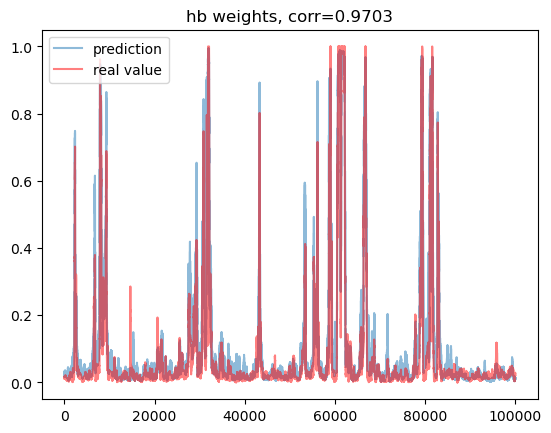

In [32]:
plt.plot(pred2L2,alpha=0.5,label="prediction")
plt.plot(Y_chr2L,alpha=0.5,label="real value",color="red")
plt.legend()
plt.title('hb weights, corr=' + str(np.round(corr2_2L,4)))
plt.show()

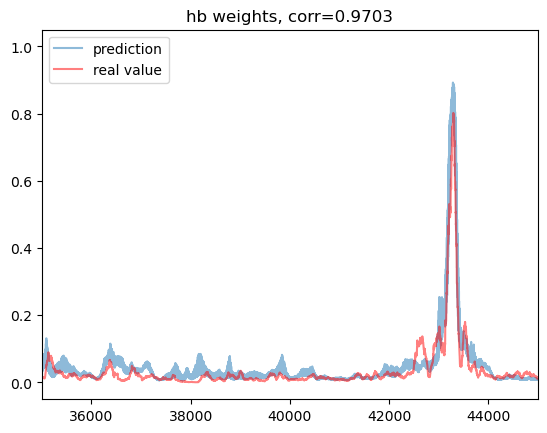

In [37]:
#prediction plot on 2L
#plt.subplot(1,2,1)
#plt.plot(pred2L,alpha=0.5,label="prediction")
#plt.plot(Y_chr2L,alpha=0.5,label="real value")
#plt.legend()
#plt.xlim((50000, 60_000))
#plt.ylabel('signal')
#plt.title('homebrew weights, corr=' +str(np.round(corr1_2L,4)))
#plt.subplot(1,2,2)
plt.plot(pred2L2,alpha=0.5,label="prediction")
plt.plot(Y_chr2L,alpha=0.5,label="real value",color="red")
plt.legend()
plt.xlim((35000, 45_000))
plt.title('hb weights, corr=' + str(np.round(corr2_2L,4)))
plt.show()

In [52]:
np.corrcoef(Y_chr2L[50000:60000].ravel(),pred2L2[50000:60000].ravel())[0][1],0.9829676916212687

(0.9188759226770489, 0.9829676916212687)

In [16]:
#pred with old weights
#pred3L=model.predict(X_chr3L, batch_size=1024) 
#pred with new weights
pred3L2=model2.predict(X_chr3L, batch_size=1024)

98/98 [==============================] - 39s 395ms/step


In [35]:
#corr1_3L = np.corrcoef(Y_chr3L[50000:60000].ravel(),pred3L[50000:60000].ravel())[0][1]
corr2_3L = np.corrcoef(Y_chr3L.ravel(),pred3L2.ravel())[0][1]
#print('homebrew weights correlation on chr 3L= ' , corr1_3L)
print('scikit weights correlation on chr 3L = ' , corr2_3L)

scikit weights correlation on chr 3L =  -0.03540745945508407


In [ ]:
#prediction plot on 3L
#plt.subplot(1,2,1)
#plt.plot(pred3L,alpha=0.5,label="prediction")
#plt.plot(Y_chr3L,alpha=0.5,label="real value")
#plt.xlim((30000, 60_000))
#plt.legend()
#plt.title('homebrew weights, corr='+str(np.round(corr1_3L,4)))
#plt.ylabel('signal')
#plt.subplot(1,2,2)
plt.plot(pred3L2,alpha=0.5,label="prediction")
plt.plot(Y_chr3L,alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.title('scikit weights, corr='+str(np.round(corr2_3L,4)))
plt.show()

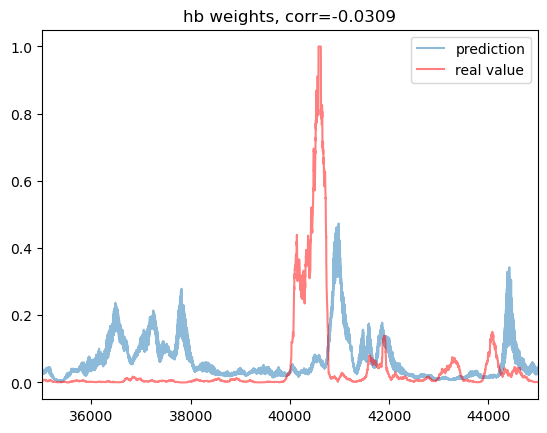

In [34]:
#prediction plot on 3L
#plt.subplot(1,2,1)
#plt.plot(pred3L,alpha=0.5,label="prediction")
#plt.plot(Y_chr3L,alpha=0.5,label="real value")
#plt.xlim((30000, 60_000))
#plt.legend()
#plt.title('homebrew weights, corr='+str(np.round(corr1_3L,4)))
#plt.ylabel('signal')
#plt.subplot(1,2,2)
plt.plot(pred3L2,alpha=0.5,label="prediction")
plt.plot(Y_chr3L,alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.title('hb weights, corr='+str(np.round(corr2_3L,4)))
plt.show()

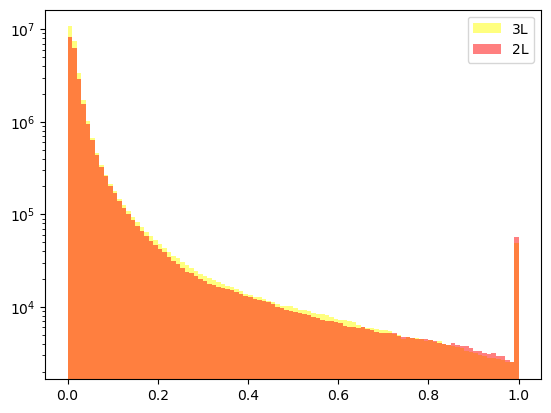

In [23]:

plt.hist(Y_chr3L,bins=100,alpha=0.5,label="3L",color="yellow")
plt.hist(Y_chr2L,bins=100,alpha=0.5,label="2L",color="red")
plt.yscale("log")
plt.legend()

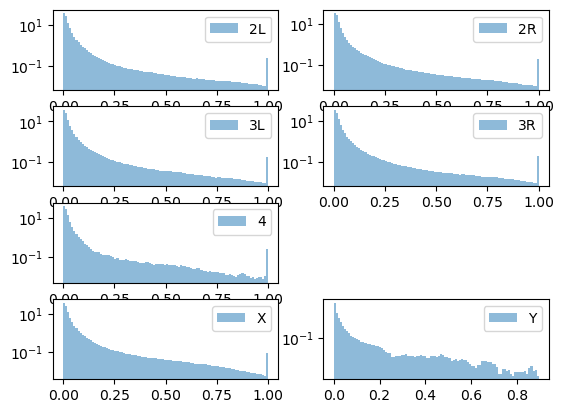

In [19]:
plt.subplot(4,2,1)
plt.yscale("log")
plt.hist(Y_chr2L,bins=100,alpha=0.5,label="2L",density=True)
plt.legend()
plt.subplot(4,2,2)
plt.yscale("log")
plt.hist(Y_chr2R,bins=100,alpha=0.5,label="2R",density=True)
plt.legend()
plt.subplot(4,2,3)
plt.yscale("log")
plt.hist(Y_chr3L,bins=100,alpha=0.5,label="3L",density=True)
plt.legend()
plt.subplot(4,2,4)
plt.yscale("log")
plt.hist(Y_chr3R,bins=100,alpha=0.5,label="3R",density=True)
plt.legend()
plt.subplot(4,2,5)
plt.yscale("log")
plt.hist(Y_chr4,bins=100,alpha=0.5,label="4",density=True)
plt.legend()
plt.yscale("log")
plt.subplot(4,2,7)
plt.hist(Y_chrX,bins=100,alpha=0.5,label="X",density=True)
plt.legend()
plt.yscale("log")
plt.subplot(4,2,8)
plt.hist(Y_chrY,bins=100,alpha=0.5,label="Y",density=True)
plt.legend()
plt.yscale("log")
plt.legend()

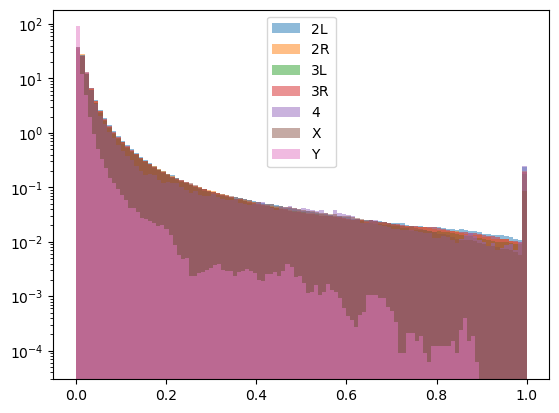

In [20]:
plt.hist(Y_chr2L,bins=100,alpha=0.5,label="2L",density=True)

plt.hist(Y_chr2R,bins=100,alpha=0.5,label="2R",density=True)

plt.hist(Y_chr3L,bins=100,alpha=0.5,label="3L",density=True)

plt.hist(Y_chr3R,bins=100,alpha=0.5,label="3R",density=True)

plt.hist(Y_chr4,bins=100,alpha=0.5,label="4",density=True)

plt.hist(Y_chrX,bins=100,alpha=0.5,label="X",density=True)

plt.hist(Y_chrY,bins=100,alpha=0.5,label="Y",density=True)

plt.yscale("log")
plt.legend()

In [ ]:
plt.hist(Y_chr2L,bins=100,alpha=0.5,label="2L")
plt.yscale("log")
plt.hist(Y_chr2R,bins=100,alpha=0.5,label="2R")
plt.yscale("log")
plt.hist(Y_chr3L,bins=100,alpha=0.5,label="3L")
plt.yscale("log")
plt.hist(Y_chr3R,bins=100,alpha=0.5,label="3R")
plt.legend()
plt.subplot(4,2,5)
plt.yscale("log")
plt.hist(Y_chr4,bins=100,alpha=0.5,label="4")
plt.legend()
plt.yscale("log")
plt.subplot(4,2,7)
plt.hist(Y_chrX,bins=100,alpha=0.5,label="X")
plt.legend()
plt.yscale("log")
plt.subplot(4,2,8)
plt.hist(Y_chrY,bins=100,alpha=0.5,label="Y")
plt.legend()
plt.yscale("log")
plt.legend()

In [17]:

import statsmodels.api as sm

acorr = sm.tsa.acf(Y_chr3L, nlags = len(range(100))-1)

In [18]:
acorr

array([1.        , 0.99941188, 0.9988183 , 0.99807997, 0.99729703,
       0.99650317, 0.99549149, 0.99440132, 0.99324699, 0.99200263,
       0.99091548, 0.9896678 , 0.98838099, 0.98699624, 0.9855389 ,
       0.98405998, 0.98249059, 0.98086801, 0.97918135, 0.97741815,
       0.97562489, 0.97377692, 0.9718893 , 0.96995247, 0.96796523,
       0.96593445, 0.96384826, 0.96170835, 0.95951583, 0.95726982,
       0.95497275, 0.95262283, 0.95022657, 0.94778233, 0.94530068,
       0.94277774, 0.94021492, 0.93761135, 0.93496979, 0.93229149,
       0.92958284, 0.92684183, 0.92407141, 0.92126742, 0.91843142,
       0.91556542, 0.91266664, 0.90973353, 0.90677115, 0.9037757 ,
       0.90075109, 0.89768986, 0.89459679, 0.89148683, 0.8883513 ,
       0.88519806, 0.88201221, 0.87878654, 0.87555096, 0.87229005,
       0.86901918, 0.86566661, 0.86220507, 0.85872822, 0.85523595,
       0.85177241, 0.84831306, 0.84482363, 0.84134347, 0.83786772,
       0.83449797, 0.83124937, 0.82799459, 0.82475122, 0.82149

In [9]:
#create data set for prediction (3L and 3R)
Y_chr3L=val[len2L+len2R:len2L+len2R+len3L]
chr3L=np.load('/home/florian/projet/r6.16/seq.npz')['3L']
X_chr3L=[]
for i in range(10_000_000,10_100_000):
    X_chr3L.append(chr3L[i-1000:i+1001])
X_chr3L = np.array(X_chr3L)

Y_chr3R=val[len2L+len2R+len3L:len2L+len2R+len3L+len3R]
chr3R=np.load('/home/florian/projet/r6.16/seq.npz')['3R']
X_chr3R=[]
for i in range(10_000_000,10_100_000):
    X_chr3R.append(chr3R[i-1000:i+1001])
X_chr3R = np.array(X_chr3R)

In [10]:
#pred for each dropout rate:
preds={}
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
        tf.keras.layers.MaxPooling1D(pool_size=(2)),
        tf.keras.layers.Dropout(i),
        tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=(2)),
        tf.keras.layers.Dropout(i),
        tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid")
        ])
    print("predicting with dropout = ",str(i))
    model2.load_weights('/home/florian/projet/models/new_model_dropout{}/cp.cpkt'.format(str(i)))
    preds['pred3L{}'.format(str(int(i*10)))]=model2.predict(X_chr3L,batch_size=1024)
    preds['pred3R{}'.format(str(int(i*10)))]=model2.predict(X_chr3R,batch_size=1024)
    

predicting with dropout =  0.1
98/98 [==============================] - 39s 396ms/step
predicting with dropout =  0.2
98/98 [==============================] - 39s 394ms/step
predicting with dropout =  0.3
98/98 [==============================] - 39s 393ms/step
predicting with dropout =  0.4
98/98 [==============================] - 39s 395ms/step
predicting with dropout =  0.5
98/98 [==============================] - 38s 392ms/step
predicting with dropout =  0.6
98/98 [==============================] - 39s 397ms/step
predicting with dropout =  0.7
98/98 [==============================] - 39s 394ms/step


In [11]:
os.chdir('/home/florian/projet/models')
np.savez_compressed('preds_for_dropouts',**preds)

In [19]:
preds=np.load('/home/florian/projet/models/preds_for_dropouts.npz')

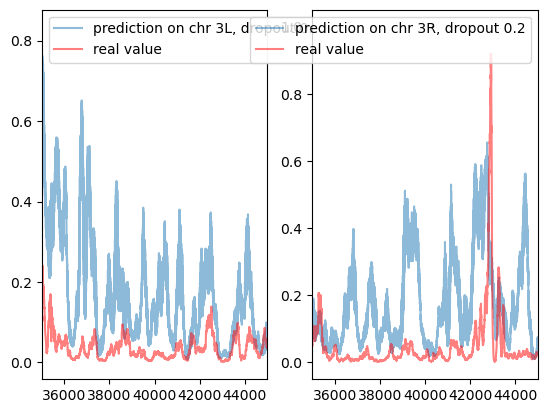

In [30]:
plt.subplot(1,2,1)
plt.plot(preds['pred3L2'],alpha=0.5,label="prediction on chr 3L, dropout 0.2")
plt.plot(Y_chr3L[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.subplot(1,2,2)
plt.plot(preds['pred3R2'],alpha=0.5,label="prediction on chr 3R, dropout 0.2")
plt.plot(Y_chr3R[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.show()

In [33]:
print("correlation 3L", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),preds['pred3L2'].ravel())[0][1]))
print("correlation 3R", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),preds['pred3R2'].ravel())[0][1]))

correlation 3L 0.36706373181997826
correlation 3R -0.09779563001454147


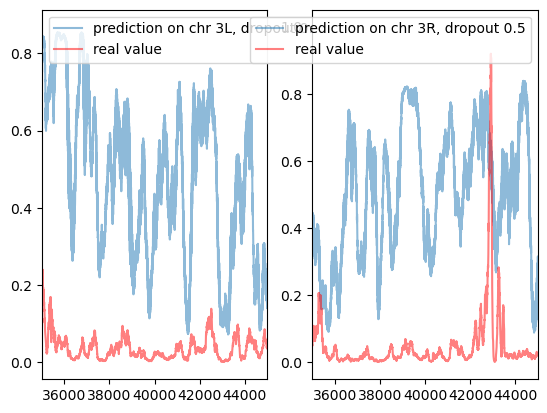

In [31]:
plt.subplot(1,2,1)
plt.plot(preds['pred3L5'],alpha=0.5,label="prediction on chr 3L, dropout 0.5")
plt.plot(Y_chr3L[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.subplot(1,2,2)
plt.plot(preds['pred3R5'],alpha=0.5,label="prediction on chr 3R, dropout 0.5")
plt.plot(Y_chr3R[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.show()

In [34]:
print("correlation 3L", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),preds['pred3L5'].ravel())[0][1]))
print("correlation 3R", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),preds['pred3R5'].ravel())[0][1]))

correlation 3L 0.35149833022954224
correlation 3R -0.07777071006877877


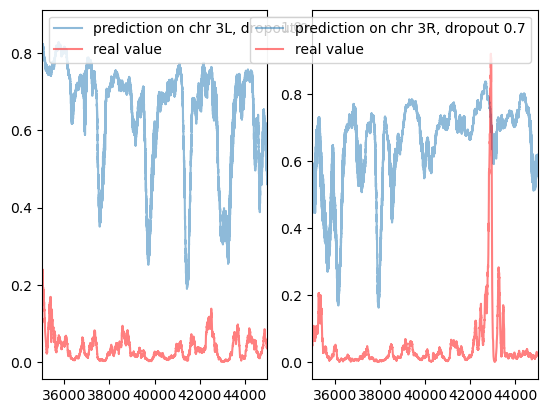

In [32]:
plt.subplot(1,2,1)
plt.plot(preds['pred3L7'],alpha=0.5,label="prediction on chr 3L, dropout 0.7")
plt.plot(Y_chr3L[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.subplot(1,2,2)
plt.plot(preds['pred3R7'],alpha=0.5,label="prediction on chr 3R, dropout 0.7")
plt.plot(Y_chr3R[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()
plt.show()

In [35]:
print("correlation 3L", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),preds['pred3L7'].ravel())[0][1]))
print("correlation 3R", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),preds['pred3R7'].ravel())[0][1]))

correlation 3L 0.30344836477691167
correlation 3R -0.03363137349841362


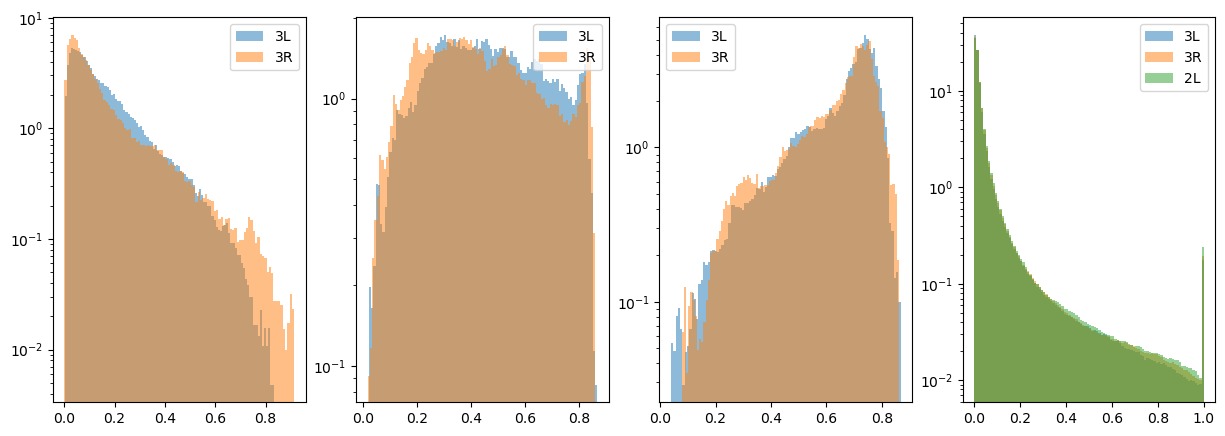

In [21]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)

plt.hist(preds['pred3L2'],bins=100,alpha=0.5,label="3L",density=True)

plt.hist(preds['pred3R2'],bins=100,alpha=0.5,label="3R",density=True)

plt.yscale("log")
plt.legend()

plt.subplot(1,4,2)

plt.hist(preds['pred3L5'],bins=100,alpha=0.5,label="3L",density=True)

plt.hist(preds['pred3R5'],bins=100,alpha=0.5,label="3R",density=True)

plt.yscale("log")
plt.legend()

plt.subplot(1,4,3)

plt.hist(preds['pred3L7'],bins=100,alpha=0.5,label="3L",density=True)

plt.hist(preds['pred3R7'],bins=100,alpha=0.5,label="3R",density=True)

plt.yscale("log")
plt.legend()

plt.subplot(1,4,4)
plt.hist(Y_chr3L,bins=100,alpha=0.5,label="3L",density=True)
plt.hist(Y_chr3R,bins=100,alpha=0.5,label="3R",density=True)
plt.hist(Y_chr2L,bins=100,alpha=0.5,label="2L",density=True)

plt.yscale("log")
plt.legend()

In [10]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
print("predicting with dropout = ",str(0.1))
model2.load_weights('/home/florian/projet/models/new_model_dropout{}/cp.cpkt'.format(str(0.1)))
pred3L2=model2.predict(X_chr3L,batch_size=1024)

predicting with dropout =  0.1
98/98 [==============================] - 39s 396ms/step


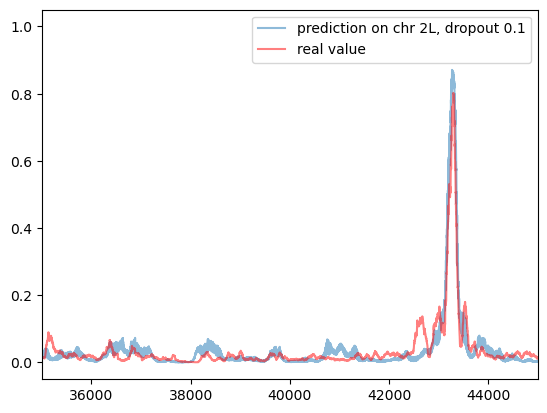

In [58]:
plt.plot(pred2L2,alpha=0.5,label="prediction on chr 2L, dropout 0.1")
plt.plot(Y_chr2L,alpha=0.5,label="real value",color="red")
plt.xlim((35000, 45_000))
plt.legend()

In [59]:
print("correlation 2L", str(np.corrcoef(Y_chr2L.ravel(),pred2L.ravel())[0][1]))

correlation 2L 0.8998849331716425


In [46]:
plt.plot(pred3L2,alpha=0.5,label="prediction on chr 3L, dropout 0.1")
plt.plot(Y_chr3L[10_000_000:10_100_000],alpha=0.5,label="real value",color="red")
plt.xlim((35000, 35_100))
plt.legend()

NameError: name 'pred3L2' is not defined

In [16]:
print("correlation 3L", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),pred3L2.ravel())[0][1]))

correlation 3L 0.36236489049649306


In [9]:
Y_chr4=val[len2L+len2R+len3L+len3R:len2L+len2R+len3L+len3R+len4]
chr4=np.load('/home/florian/projet/r6.16/seq.npz')['4']
X_chr4=[]
for i in range(20000,120_000):
    X_chr4.append(chr4[i-1000:i+1001])
X_chr4 = np.array(X_chr4)


In [10]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])
model2.load_weights('/home/florian/projet/models/reverse_training/cp.cpkt')
pred2L=model2.predict(X_chr2L,batch_size=1024)

98/98 [==============================] - 39s 393ms/step


In [40]:
pred2L

array([[0.15776375],
       [0.06811095],
       [0.13934891],
       ...,
       [0.02481837],
       [0.03791698],
       [0.02287618]], dtype=float32)

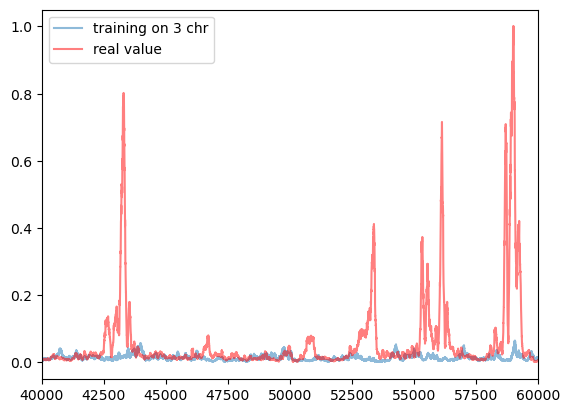

: 

In [12]:
plt.plot(pred2L,alpha=0.5,label="training on 3 chr")
plt.plot(Y_chr2L,alpha=0.5,label="real value",color="red")
plt.xlim((40000, 60000))
plt.legend()

In [26]:
print("correlation 3L", str(np.corrcoef(Y_chr3L[10_000_000:10_100_000].ravel(),pred3L.ravel())[0][1]))

correlation 3L 0.40129121669063694


In [ ]:
#prediction
def pred(model,chr):
    